In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocess_kgptalkie as ps

In [2]:
df = pd.read_csv('D:\Downloads\IMDB Dataset.csv')

In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df.shape

(50000, 2)

In [5]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df['review'][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

In [8]:
df['review'].apply(lambda x: ps.get_wordcounts(x))

0        307
1        162
2        166
3        138
4        230
        ... 
49995    194
49996    112
49997    230
49998    212
49999    129
Name: review, Length: 50000, dtype: int64

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [10]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Download NLTK resources (you only need to do this once)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Building Functions

In [11]:
import contractions
def processing_func(text):
    res=contractions.fix(text)
    return res

import string
def remove_punctuation(text):
    regular_punct = list(string.punctuation)
    for punc in regular_punct:
        if punc in text:
            text = text.replace(punc, ' ')
    return text.strip()

def stem_text(text):
    # Initialize the Porter Stemmer
    stemmer = PorterStemmer()
    
    # Tokenize the text (split it into words)
    words = nltk.word_tokenize(text)
    
    # Apply stemming to each word and remove stopwords
    stemmed_words = [stemmer.stem(word) for word in words if word.lower() not in stopwords.words('english')]
    
    # Join the stemmed words back into a sentence
    stemmed_text = ' '.join(stemmed_words)
    
    return stemmed_text

import itertools
def remove_duplicates_car(tweet):
    new_tweet = ''.join(ch for ch, _ in itertools.groupby(tweet))
    return new_tweet


# Preprocessing

In [12]:
    df['word_counts']=df['review'].apply(lambda x: ps.get_wordcounts(x))
    df['char_counts']=df['review'].apply(lambda x: ps.get_charcounts(x))
    df['avg_wordlength']=df['review'].apply(lambda x: ps.get_avg_wordlength(x))
    df['stopwords_counts']=df['review'].apply(lambda x: ps.get_stopwords_counts(x))
    
    df['review']=df['review'].apply(lambda x: ps.remove_stopwords(x))
    df['review']=df['review'].apply(lambda x: ps.remove_html_tags(x)) # na7i les balises html
    df['review']=df['review'].str.lower()
    df['review'] = df['review'].apply(remove_punctuation)
    df['review'] = df['review'].apply(processing_func)
    df['review'] = df['review'].apply(stem_text)
    df['review'] = df['review'].apply(remove_duplicates_car)
    
    df['review'] = df['review'].apply(lambda x: ps.remove_emails(x))
    df['review'] = df['review'].apply(lambda x: ps.remove_html_tags(x))
    df['review'] = df['review'].apply(lambda x: ps.remove_urls(x))

    df['review'] = df['review'].apply(lambda x: ps.remove_special_chars(x))
    df['review'] = df['review'].apply(lambda x: ps.remove_accented_chars(x))


C:\Users\malek\AppData\Local\Programs\Python\Python310\lib\site-packages\preprocess_kgptalkie\utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [13]:
import seaborn as sns

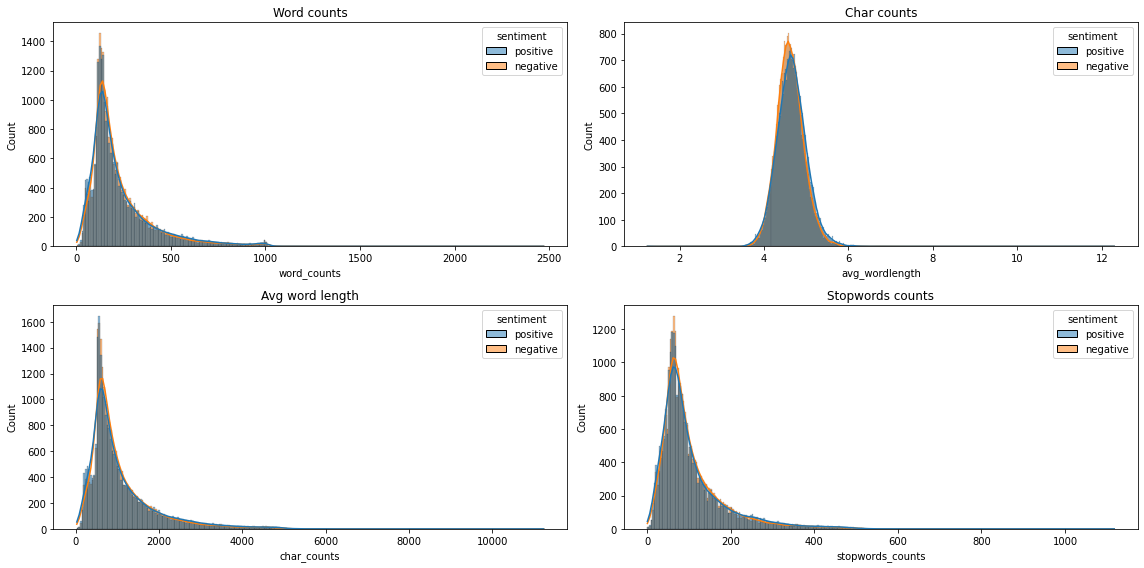

In [14]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
#sns.barplot(x='sentiment',y="word_counts", data=df)
sns.histplot(data=df, x='word_counts', hue="sentiment",kde=True)
plt.title('Word counts')

plt.subplot(2,2,2)
sns.histplot(data=df, x='avg_wordlength', hue="sentiment",kde=True)
plt.title('Char counts')

plt.subplot(2,2,3)
sns.histplot(data=df, x='char_counts', hue="sentiment",kde=True)
plt.title('Avg word length')

plt.subplot(2,2,4)
sns.histplot(data=df, x='stopwords_counts', hue="sentiment",kde=True)
plt.title('Stopwords counts')


plt.tight_layout()
plt.show()

## MODEL

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report


In [16]:
X_train,X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'],test_size=0.3,random_state=42, stratify=df['sentiment'])

In [17]:
X_train.shape, y_train.shape


((35000,), (35000,))

In [18]:
X_test.shape,y_test.shape

((15000,), (15000,))

###  Trying Different classifiers

In [19]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
# from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from sklearn.svm import SVC

# # Define different classifiers
# classifiers = {
#     'LinearSVC': LinearSVC(),
#     'MultinomialNB': MultinomialNB(),
#     'RandomForestClassifier': RandomForestClassifier(),
#     'GradientBoostingClassifier': GradientBoostingClassifier(),
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'DecisionTreeClassifier': DecisionTreeClassifier(),
#     'AdaBoostClassifier': AdaBoostClassifier(),
#     'LogisticRegression': LogisticRegression(),
#     'NaiveBayes': GaussianNB(),
#     'NeuralNetwork': MLPClassifier(),
    
#     # Add more classifiers as needed
# }

# # Iterate over classifiers
# for clf_name, clf in classifiers.items():
#     print(f"Training and evaluating {clf_name}...")
    
#     # Create a pipeline with TF-IDF vectorizer and the current classifier
#     model = Pipeline([
#         ('tfidf', TfidfVectorizer()),
#         ('clf', clf)
#     ])
    
#     # Fit the model on the training data
#     model.fit(X_train, y_train)
    
#     # Make predictions on the test data
#     y_pred = model.predict(X_test)
    
#     # Calculate accuracy and print classification report
#     accuracy = accuracy_score(y_test, y_pred)
    
#     print(f"Accuracy of {clf_name}: {accuracy}")

In [21]:
from sklearn.svm import SVC
clf= Pipeline([('tfidf',TfidfVectorizer()),('clf',SVC())])

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names=clf.classes_)

In [ ]:
accuracy_score(y_test, y_pred)

### Test Data Preprocessing

In [ ]:
text="I can't deny that this film is a cinematic achievement. The acting, direction, and cinematography are all top-notch. However, the story left me emotionally drained, and I'm not sure if that's a good thing or a bad thing."

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocess_kgptalkie as ps

# Convert text to lowercase

# Apply processing function 
text = processing_func(text)
# Apply stemming function 
text = stem_text(text)

text = text.lower()

text = ps.remove_emails(text)
text = ps.remove_urls(text)

text = ps.remove_special_chars(text)
text = ps.remove_accented_chars(text)

text = ps.remove_stopwords(text)

# Remove HTML tags 
text = ps.remove_html_tags(text)

# Remove punctuation 
text = remove_punctuation(text)

# Apply remove duplicates function 
text = remove_duplicates_car(text)





In [ ]:
stem_text(text)

In [ ]:
text

In [ ]:
clf.predict([text])

In [ ]:
# from pickle import *
# f= open("sentiment_analysis.pkl",'wb')
# dump(clf,f)
